In [1]:
### import collections
import json
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from mab import algs


class ONN(nn.Module):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, batch_size=1,
                 b=0.99, n=0.01, s=0.2, use_cuda=False):
        super(ONN, self).__init__()

        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA :]")

        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.features_size = features_size
        self.max_num_hidden_layers = max_num_hidden_layers
        self.qtd_neuron_per_hidden_layer = qtd_neuron_per_hidden_layer
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.b = Parameter(torch.tensor(
            b), requires_grad=False).to(self.device)
        self.n = Parameter(torch.tensor(
            n), requires_grad=False).to(self.device)
        self.s = Parameter(torch.tensor(
            s), requires_grad=False).to(self.device)

        self.hidden_layers = []
        self.output_layers = []

        self.hidden_layers.append(
            nn.Linear(features_size, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers - 1):
            self.hidden_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers):
            self.output_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, n_classes))

        self.hidden_layers = nn.ModuleList(self.hidden_layers).to(self.device)
        self.output_layers = nn.ModuleList(self.output_layers).to(self.device)

        self.alpha = Parameter(torch.Tensor(self.max_num_hidden_layers).fill_(1 / (self.max_num_hidden_layers + 1)),
                               requires_grad=False).to(
            self.device)

        self.loss_array = []
        self.tp=0.1
        self.tn=0.1
        self.fp=0.1
        self.fn=0.1
        self.bal_acc = 0
        self.bal_acc_list = []
        self.sen = 0
        self.spec = 0
        
        self.protected_pos = 0.1
        self.protected_neg = 0.1
        self.non_protected_pos = 0.1
        self.non_protected_neg = 0.1
        self.stp_score=0
        
        self.tp_protected = 0.1
        self.fn_protected = 0.1
        self.tp_non_protected = 0.1
        self.fn_non_protected = 0.1
        self.eqop_score=0

    def zero_grad(self):
        for i in range(self.max_num_hidden_layers):
            self.output_layers[i].weight.grad.data.fill_(0)
            self.output_layers[i].bias.grad.data.fill_(0)
            self.hidden_layers[i].weight.grad.data.fill_(0)
            self.hidden_layers[i].bias.grad.data.fill_(0)

    def update_weights(self, X, Y, weight, show_loss, test):
        Y = torch.from_numpy(Y).to(self.device)
        if test=='yes':
            prediction_1 = self.predict_1(X)
            self.update_eval_metrics(prediction_1,Y)
            self.update_stp_score(prediction_1,X)
            self.update_eqop_score(prediction_1,X,Y)
        
        predictions_per_layer = self.forward(X)
        losses_per_layer = []

        for out in predictions_per_layer:
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(out.view(self.batch_size, self.n_classes), Y.view(
                self.batch_size).long())
            losses_per_layer.append(loss*weight)

        w = [None] * len(losses_per_layer)
        b = [None] * len(losses_per_layer)
        
        with torch.no_grad():     #Context-manager that disabled gradient calculation
            self.weights_output_layers = list()
            self.biases_output_layers = list()
            for i in range(len(losses_per_layer)):
                losses_per_layer[i].backward(retain_graph=True)
                self.output_layers[i].weight.data -= self.n * \
                                                   self.alpha[i] * self.output_layers[i].weight.grad.data
                self.output_layers[i].bias.data -= self.n * \
                                                 self.alpha[i] * self.output_layers[i].bias.grad.data
                self.weights_output_layers.append(self.output_layers[i].weight.data) 
                self.biases_output_layers.append(self.output_layers[i].bias.data)
                
                for j in range(i + 1):
                    if w[j] is None:
                        w[j] = self.alpha[i] * self.hidden_layers[j].weight.grad.data
                        b[j] = self.alpha[i] * self.hidden_layers[j].bias.grad.data
                    else:
                        w[j] += self.alpha[i] * self.hidden_layers[j].weight.grad.data
                        b[j] += self.alpha[i] * self.hidden_layers[j].bias.grad.data
                self.zero_grad()
            self.weights_hidden_layers= list()
            self.biases_hidden_layers = list()
            
            for i in range(len(losses_per_layer)):
                self.hidden_layers[i].weight.data -= self.n * w[i]
                self.hidden_layers[i].bias.data -= self.n * b[i]
                self.weights_hidden_layers.append(self.hidden_layers[i].weight.data)
                self.biases_hidden_layers.append(self.hidden_layers[i].bias.data)
            for i in range(len(losses_per_layer)):
                self.alpha[i] *= torch.pow(self.b, losses_per_layer[i])
                self.alpha[i] = torch.max(
                  self.alpha[i], self.s / self.max_num_hidden_layers)

        z_t = torch.sum(self.alpha)

        self.alpha = Parameter(
            self.alpha / z_t, requires_grad=False).to(self.device)
        if show_loss:
            
            real_output = torch.sum(torch.mul(
                self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, self.batch_size).view(
                    self.max_num_hidden_layers, self.batch_size, 1), predictions_per_layer), 0)
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(real_output.view(self.batch_size, self.n_classes), Y.view(self.batch_size).long())
            self.loss_array.append(loss)
            if (len(self.loss_array) % 1000) == 0:
                #print("WARNING: Set 'show_loss' to 'False' when not debugging. "
                #      "It will deteriorate the fitting performance.")
                loss = torch.Tensor(self.loss_array).mean().cpu().numpy()
                #print("Alpha:" + str(self.alpha.data.cpu().numpy()))
                print("Training Loss: " + str(loss))
                print("Balanced accuracy: " + str(self.bal_acc))
                print("Sensitivity: " + str(self.sen))
                print("Specificity: " + str(self.spec))
                print("Stp score: " + str(self.stp_score))
                print("Eqop score: " + str(self.eqop_score))
                self.loss_array.clear()

    def get_weights(self,network_name):
        
        if network_name == 'global':
            weights_output_layers = list()
            biases_output_layers = list()
            weights_hidden_layers = list()
            biases_hidden_layers= list()
            for i in range(self.max_num_hidden_layers):
                weights_output_layers.append(self.output_layers[i].weight.data) 
                biases_output_layers.append(self.output_layers[i].bias.data)
                weights_hidden_layers.append(self.hidden_layers[i].weight.data)
                biases_hidden_layers.append(self.hidden_layers[i].bias.data)
               
            return self.alpha, weights_output_layers, biases_output_layers, weights_hidden_layers, biases_hidden_layers
        else:
            return self.alpha, self.weights_output_layers, self.biases_output_layers, self.weights_hidden_layers, self.biases_hidden_layers
    
    def set_weights(self, alpha, w_output_layer, b_output_layer, w_hidden_layer, b_hidden_layer):
        
        for i in range(self.max_num_hidden_layers):
            self.alpha[i] = alpha[i].clone().detach()
            self.output_layers[i].weight.data = w_output_layer[i].clone().detach()
            self.output_layers[i].bias.data = b_output_layer [i].clone().detach()
            self.hidden_layers[i].weight.data =  w_hidden_layer [i].clone().detach()
            self.hidden_layers[i].bias.data = b_hidden_layer [i].clone().detach()    
    def forward(self, X):
        hidden_connections = []

        X = torch.from_numpy(X).float().to(self.device)

        x = F.relu(self.hidden_layers[0](X))
        hidden_connections.append(x)

        for i in range(1, self.max_num_hidden_layers):
            hidden_connections.append(
                F.relu(self.hidden_layers[i](hidden_connections[i - 1])))

        output_class = []

        for i in range(self.max_num_hidden_layers):
            output_class.append(self.output_layers[i](hidden_connections[i]))

        pred_per_layer = torch.stack(output_class)

        return pred_per_layer

    def validate_input_X(self, data):
        
        if len(data.shape) != 2:
            raise Exception(
                "Wrong dimension for this X data. It should have only two dimensions.")

    def validate_input_Y(self, data):
        if len(data.shape) != 1:
            raise Exception(
                "Wrong dimension for this Y data. It should have only one dimensions.")

    def partial_fit_(self, X_data, Y_data, weight, show_loss=True, test='yes'):
        
        self.validate_input_X(X_data)
        self.validate_input_Y(Y_data)
        self.update_weights(X_data, Y_data, weight, show_loss, test)

    def partial_fit(self, X_data, Y_data, weight, show_loss=True, test='yes'):
        
        self.partial_fit_(X_data, Y_data, weight, show_loss, test)

    def reset_eval_metrics(self):
        self.tp=0.1
        self.tn=0.1
        self.fp=0.1
        self.fn=0.1
        self.bal_acc = 0
        self.bal_acc_list = []
        self.sen = 0
        self.spec = 0
        
        self.protected_pos = 0.1
        self.protected_neg = 0.1
        self.non_protected_pos = 0.1
        self.non_protected_neg = 0.1
        self.stp_score=0
        
        self.tp_protected = 0.1
        self.fn_protected = 0.1
        self.tp_non_protected = 0.1
        self.fn_non_protected = 0.1
        self.eqop_score=0
    def update_eval_metrics(self,prediction_1,Y):
        if prediction_1==1 and Y==1:
            self.tp+=1
        elif prediction_1==1 and Y==0:
            self.fp+=1
        elif prediction_1==0 and Y==1:
            self.fn+=1
        else:
            self.tn+=1
        
        self.sen = self.tp/(self.tp + self.fn)
        self.spec= self.tn/(self.tn + self.fp)
        self.bal_acc = (self.sen + self.spec)/2
        self.bal_acc_list.append(self.bal_acc)
            
    def update_stp_score(self,prediction_1,X):
        if X[0][sa_index] == p_Group:
            if prediction_1 == 1:
                self.protected_pos += 1.
            else:
                self.protected_neg += 1.
        else:
            if prediction_1 == 1:
                self.non_protected_pos += 1.
            else:
                self.non_protected_neg += 1.
            
        C_prot = (self.protected_pos) / (self.protected_pos + self.protected_neg)
        C_non_prot = (self.non_protected_pos) / (self.non_protected_pos + self.non_protected_neg)

        self.stp_score = C_non_prot - C_prot
    
    def update_eqop_score(self,prediction_1,X,Y):
        if X[0][sa_index] == p_Group:
            if prediction_1==1 and Y==1:
                self.tp_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_protected += 1.
        else:
            if prediction_1==1 and Y==1:
                self.tp_non_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_non_protected += 1.
            
        tpr_protected = self.tp_protected / (self.tp_protected + self.fn_protected)
        tpr_non_protected = self.tp_non_protected / (self.tp_non_protected + self.fn_non_protected)
        self.eqop_score = tpr_non_protected - tpr_protected
    
    def predict_1(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, 1).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()
    def predict_(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, len(X_data)).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()

    def predict(self, X_data):
        pred = self.predict_(X_data)
        return pred

    def export_params_to_json(self):
        state_dict = self.state_dict()
        params_gp = {}
        for key, tensor in state_dict.items():
            params_gp[key] = tensor.cpu().numpy().tolist()

        return json.dumps(params_gp)

    def load_params_from_json(self, json_data):
        params = json.loads(json_data)
        o_dict = collections.OrderedDict()
        for key, tensor in params.items():
            o_dict[key] = torch.tensor(tensor).to(self.device)
        self.load_state_dict(o_dict)


class ONN_THS(ONN):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=0.99, n=0.01,
                 s=0.2, e=[0.5, 0.35, 0.2, 0.1, 0.05], use_cuda=False):
        super().__init__(features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=b, n=n, s=s,
                         use_cuda=use_cuda)
        self.e = Parameter(torch.tensor(e), requires_grad=False)
        self.arms_values = Parameter(
            torch.arange(n_classes), requires_grad=False)
        self.explorations_mab = []

        for i in range(n_classes):
            self.explorations_mab.append(algs.ThompsomSampling(len(e)))

    def partial_fit(self, X_data, Y_data, exp_factor, show_loss=True):
        self.partial_fit_(X_data, Y_data, show_loss)
        self.explorations_mab[Y_data[0]].reward(exp_factor)

    def predict(self, X_data):
        pred = self.predict_(X_data)[0]
        exp_factor = self.explorations_mab[pred].select()[0]
        if np.random.uniform() < self.e[exp_factor]:
            removed_arms = self.arms_values.clone().numpy().tolist()
            removed_arms.remove(pred)
            return random.choice(removed_arms), exp_factor

        return pred, exp_factor


In [2]:
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.datasets import make_imbalance
import numpy as np

In [3]:
# import urllib2
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

# import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)


def load_adult():
    FEATURES_CLASSIFICATION = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation",
                               "relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country"] #features to be used for classification
    CONT_VARIABLES = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "y" # the decision variable
    SENSITIVE_ATTRS = ["sex"]
    
    COMPAS_INPUT_FILE = "./datasets/adult2.csv"

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df.dropna()
    # convert to np arra
    data = df.to_dict('list')

    for k in data.keys():
        data[k] = np.array(data[k])

    """ Feature normalization and one hot encoding """
    # convert class label 0 to -1
    y = data[CLASS_FEATURE]
    y[y==0] = -1
    X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
    x_control = defaultdict(list)
    
    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            vals = preprocessing.scale(vals) # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col
        
        else: # for binary categorical variables, the label binarizer uses just one var instead of two
            lb = preprocessing.LabelBinarizer()   #LabelEncoder() # Label Encoder
            lb.fit(vals)
            vals = lb.transform(vals)
            #vals = np.reshape(vals, (len(y), -1))
            #if attr =="sex": 
            #    print(lb.classes_)
            #    print(lb.transform(lb.classes_))
        
        # add to sensitive features dict
        if attr in SENSITIVE_ATTRS:
            x_control[attr] = vals

        # add to learnable features
        X = np.hstack((X, vals))

        if attr in CONT_VARIABLES: # continuous feature, just append the name
            feature_names.append(attr)
        else: # categorical features
            if vals.shape[1] == 1: # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in lb.classes_: # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))


    # convert the sensitive feature to 1-d array
    x_control = dict(x_control)
    for k in x_control.keys():
        assert(x_control[k].shape[1] == 1) # make sure that the sensitive feature is binary after one hot encoding
        x_control[k] = np.array(x_control[k]).flatten()

    
    
    return X, y, feature_names.index(SENSITIVE_ATTRS[0]), 0, x_control


X_1,y, sa_index, p_Group, x_control= load_adult()

#print(X[0])
#print(X[0][1])
#print(sa_index)
np_Group = 1 #non-protected group's sa_value
Y_1 = []
for i in y:
    if (i == -1):
        Y_1.append(0)
    else:
        Y_1.append(1)
Y_1 = np.array(Y_1)
from sklearn.utils import shuffle
X_1, Y_1 = shuffle(X_1, Y_1)
X, x_test, Y, y_test = train_test_split(X_1,Y_1,test_size=0.2)
X, Y = X_1, Y_1

In [4]:
print(np.unique(Y_1))
list(Y_1).count(0)

[0 1]


37155

In [5]:
def k_nearest_neighbors(data, predict, k):
    #k=8
    #if len(data) >= k:
    #    warnings.warn('K is set to a value less than total voting groups!')

    distances = []
    count = 0
    for sample in data:
        euclidean_distance = np.linalg.norm(np.array(sample)-np.array(predict))
        distances.append([euclidean_distance,count])
        count+=1
    
    votes = [i[1] for i in sorted(distances)[:k]] ##votes is returning indexes of k random samples

    #vote_result = Counter(votes).most_common(9)[0][0]
    return votes
def fair_kSMOTE_algo_2(dmajor,dminor,k,r):
    S = []
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    i = 0
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,k) #from minority-p
        
        #do linear interpolation
        Sxb = []
        
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        for s in range(Nkss):
            
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
                
            x_new = x_new / (len(N)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
    
    return S

def fair_kSMOTE(dmajor,dminor_wg,dminor,k,r):
    S = []
    #Ns =  int(r*(len(dmajor) - len(dminor)))
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    #if r==-1:
    #    Nks = 1
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    i = 0
    
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,int(k/2)+1) #from minority-p
        N2= k_nearest_neighbors(dminor_wg,xb,int(k/2)) #from minority-np
    
        N3 = np.hstack((N, N2))
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        #do linear interpolation
        Sxb = []
        
        for s in range(Nkss):
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
            j = 0
            while(j < len(N2)):
                #here on random xb
                ind = N2[j]
                
                x_new = x_new + ((dminor_wg[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1    
            x_new = x_new / (len(N3)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
   
    return S





def splitYtrain_sa_value(Xtr,Ytr,minority_lable,majority_label,pp_Group=p_Group,npp_Group=np_Group): #splite Ytrain based on sensitive attribute value
    #print(Ytr)
    dmaj_p_x = []
    dmaj_np_x = []
    dmin_p_x = []
    dmin_np_x = []
    
    
    for i in range(len(Ytr)):
        if((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==pp_Group): #select minority instances with "protected" value 
            dmin_p_x.append(Xtr[i])
        elif((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==npp_Group): #select minority instances with "protected" value 
            dmin_np_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==pp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_p_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==npp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_np_x.append(Xtr[i])
    
    return dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x



#create_synth_data(window, window_label, minority_label,majority_label,5,lambda_score, 'min_p')
def create_synth_data(x, y, minority_lable,majority_label,k,r,group,pp_group,npp_group):
    
    
    dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x = splitYtrain_sa_value(x,y,minority_lable,majority_label, pp_group,npp_group)
    '''
    print("length of dmin_p_x: " + str(len(dmin_p_x)))
    print("length of dmin_np_x: " + str(len(dmin_np_x)))
    print("length of dmaj_p_x: " + str(len(dmaj_p_x)))
    print("length of dmaj_np_x: " + str(len(dmaj_np_x)))
    '''
    if len(dmin_p_x)<4:
        return -1, -1
    group_names = ['dmin_p_x', 'dmin_np_x', 'dmaj_p_x', 'dmaj_np_x']
    
    Xtr_new = []
    Ytr_new = []  
    
    
    ##Algo 3:
    
    if group =='min_p':
        dmaj_x = dmaj_p_x
        dmin_x = dmin_p_x
        
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE(dmaj_x,dmin_np_x,dmin_x,k,r)
        #x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = minority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
        
    elif group =='maj_np':
        dmaj_x = dmin_np_x
        dmin_x = dmaj_np_x
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        
        
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = majority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
    
    
    
    return Xtr_new,Ytr_new

In [6]:
#X, Y = make_classification(n_samples=50000, n_features=8, n_informative=4, n_redundant=0, n_classes=2,
#                           n_clusters_per_class=1, class_sep=3)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
X_train, y_train= X, Y

In [7]:
def online_update_classSize(train_data, label,classSize):
    theta = 0.9
    if (label not in classSize):
        up_dict = {train_data[-1]:0.5}
        classSize.update(up_dict)
    for classValue in classSize:
        if classValue == label:
            update = theta * classSize.get(classValue) + (1-theta)
            classSize[classValue] = update
        else:
            update = theta * classSize.get(classValue)
            classSize[classValue] = update

In [8]:

def create_clients(instances, labels, num_clients, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(instances, labels))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [9]:
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle

clients = create_clients(X_train, y_train, num_clients=3, initial='client')
client_index = {}
client_window = {}
client_window_label = {}
client_eddm = {}

for (client_name, data) in clients.items():
    data, label = zip(*data)
    Y = np.asarray(label)
    X = np.asarray(data)
    client_index.update({client_name:0})
    client_window.update({client_name:[]})
    client_window_label.update({client_name:[]})
    length = len(data)
    print(len(data))
#client_eddm.update({'client_1':eddm1})
#client_eddm.update({'client_2':eddm2})
#client_eddm.update({'client_3':eddm3})
print(client_index)

16280
16280
16280
{'client_1': 0, 'client_2': 0, 'client_3': 0}


In [10]:
labels = []
client_name = 'client_3'
for i in range(len(clients[client_name])):
    labels.append(clients[client_name][i][1])
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
count_ap_dict = dict(zip(unique, counts))
print(count_ap_dict)
minority_label=1
majority_label = 0        

16280
{0: 12333, 1: 3947}


In [11]:
for (client_name, data) in clients.items():
    print(client_name)
    data, label = zip(*data)
    Y = np.asarray(label)
    X = np.asarray(data)
    print(np.unique(Y))

client_1
[0 1]
client_2
[0 1]
client_3
[0 1]


In [12]:
'''
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

num_clients = 3
#adwin = ADWIN(delta =1)
window=[]
window_label = []
window_warning = []
window_label_warning = []
pos_assigned=0
pos_samples = 0
neg_samples = 0
pos_syn_samples = 0
neg_syn_samples = 0
generated_samples_per_sample = 0
imbalance_ratio = 0 #of window
minority_label=1
majority_label = 0
lambda_initial=0.1
###
ocis = 0
classSize  = {}
class_weights_dict = {}
labels = []
###
j =0
change=0
warning=0

eddm1 = EDDM()
eddm2 = EDDM()
eddm3 = EDDM()

#one global network
global_network = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

#3 networks for three clients
onn_network_1 = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_2 = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_3 = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
weight = 1
for _ in range(length):
    sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer = [],[],[],[]
    sum_alpha = []

    for (client_name, data) in clients.items():
        added_points = 0
        data, label = zip(*data)
        Y = np.asarray(label)
        X = np.asarray(data)
        
        if client_name=='client_1':
            eddm = eddm1
            onn_network = onn_network_1
        elif client_name=='client_2':
            eddm = eddm2
            onn_network = onn_network_2
        else:
            eddm = eddm3
            onn_network = onn_network_3
        i = client_index[client_name]
        if i ==0:
            print(client_index)
        else:
            if i%1000==0:
                galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer = global_network.get_weights('global')
                onn_network.set_weights(galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer)
        
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                majority_count = list(client_window_label[client_name]).count(0)
                minority_count = list(client_window_label[client_name]).count(1)
                if majority_count >  minority_count and minority_count!=0:
                    weight = int(majority_count/minority_count)
        if Y[i]==minority_label:
            onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),weight)
            
        else:
            onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
        
        
        
        #onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]))
    
        if np.size(client_window[client_name])==0:
            client_window[client_name] = np.array(X[i])
            client_window_label[client_name] = np.array(Y[i])
        else:
            client_window[client_name]=np.vstack((client_window[client_name],np.array(X[i])))
            client_window_label[client_name]= np.vstack((client_window_label[client_name],np.array(Y[i])))
        eddm.add_element(Y[i])
    

        if eddm.detected_change():
            print('Change has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
            change+=1
            client_window[client_name] = []
            client_window_label[client_name] = []
    
            
        pos_assigned = onn_network.tp+onn_network.fp-0.2
        pos_samples = onn_network.tp+onn_network.fn-0.2
        
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                if onn_network.stp_score > 0.05:
                    #print(onn_network.stp_score)
                    lambda_score = lambda_initial*(1+(onn_network.stp_score/0.2))
                    if pos_assigned <= pos_samples:
                        X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'min_p', p_Group,np_Group)
                    else:
                        X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'maj_np', p_Group,np_Group)
                    if X_syn!=-1:
                        Y_syn = np.array(Y_syn)
                        X_syn = np.array(X_syn)
                        X_syn, Y_syn = shuffle(X_syn, Y_syn, random_state=0)
                        added_points = len(Y_syn)
                        for k in range(len(X_syn)):
                            onn_network.partial_fit(np.asarray([X_syn[k, :]]), np.asarray([Y_syn[k]]), 1)
        client_alpha, client_w_output_layer, client_b_output_layer, client_w_hidden_layer, client_b_hidden_layer = onn_network.get_weights('client')
        i=i+1
        client_index.update({client_name:i})
        #scaling_factor = (client_index[client_name]+added_points)/(sum(client_index.values())+added_points)
        scaling_factor = 1/5
        print(client_index)
        p = 0
        if p==0:
            if sum_alpha==[]:
                sum_alpha = torch.mul(client_alpha, scaling_factor)
                sum_w_output_layer = client_w_output_layer
                sum_b_output_layer = client_b_output_layer
                sum_w_hidden_layer = client_w_hidden_layer
                sum_b_hidden_layer = client_b_hidden_layer
            
            
            
            
                for j in range(onn_network.max_num_hidden_layers):
                    sum_w_output_layer[j] = torch.mul(client_w_output_layer[j], scaling_factor)
                    sum_b_output_layer[j] = torch.mul(client_b_output_layer[j], scaling_factor)
                    sum_w_hidden_layer[j] = torch.mul(client_w_hidden_layer[j], scaling_factor)
                    sum_b_hidden_layer[j] = torch.mul(client_b_hidden_layer[j], scaling_factor)

            else:
                sum_alpha = torch.add(sum_alpha, torch.mul(client_alpha, scaling_factor))
                for j in range(onn_network.max_num_hidden_layers):
                    sum_w_output_layer[j] = torch.add(sum_w_output_layer[j],torch.mul(client_w_output_layer[j], scaling_factor)) 
                    sum_b_output_layer[j] = torch.add(sum_b_output_layer[j],torch.mul(client_b_output_layer[j], scaling_factor))
                    sum_w_hidden_layer[j] = torch.add(sum_w_hidden_layer[j],torch.mul(client_w_hidden_layer[j], scaling_factor)) 
                    sum_b_hidden_layer[j] = torch.add(sum_b_hidden_layer[j],torch.mul(client_b_hidden_layer[j], scaling_factor))
        
    if i%1000==0:    
        global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)
global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)            
        #global_network.set_weights(client_alpha, client_w_output_layer, client_b_output_layer, client_w_hidden_layer, client_b_hidden_layer)
        
        
        #print("change" + str(change))
#print("warning" + str(warning))
    
    
    
    
    
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))
'''

'\nimport warnings\nwarnings.simplefilter(action=\'ignore\', category=FutureWarning)\nfrom skmultiflow.drift_detection.eddm import EDDM\nfrom sklearn.utils import shuffle\nfrom sklearn.utils.class_weight import compute_class_weight\n\nnum_clients = 3\n#adwin = ADWIN(delta =1)\nwindow=[]\nwindow_label = []\nwindow_warning = []\nwindow_label_warning = []\npos_assigned=0\npos_samples = 0\nneg_samples = 0\npos_syn_samples = 0\nneg_syn_samples = 0\ngenerated_samples_per_sample = 0\nimbalance_ratio = 0 #of window\nminority_label=1\nmajority_label = 0\nlambda_initial=0.1\n###\nocis = 0\nclassSize  = {}\nclass_weights_dict = {}\nlabels = []\n###\nj =0\nchange=0\nwarning=0\n\neddm1 = EDDM()\neddm2 = EDDM()\neddm3 = EDDM()\n\n#one global network\nglobal_network = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)\n\n#3 networks for three clients\nonn_network_1 = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)\

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

num_clients = 3
#adwin = ADWIN(delta =1)
window=[]
window_label = []
window_warning = []
window_label_warning = []
pos_assigned=0
pos_samples = 0
neg_samples = 0
pos_syn_samples = 0
neg_syn_samples = 0
generated_samples_per_sample = 0
imbalance_ratio = 0 #of window
minority_label=1
majority_label = 0
lambda_initial=0.05
###
ocis = 0
classSize  = {}
class_weights_dict = {}
labels = []
###
j =0
change=0
warning=0


bal_acc_global=[] 
stp_score_global=[]
eddm1 = EDDM()
eddm2 = EDDM()
eddm3 = EDDM()

#one global network
global_network = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

#3 networks for three clients
onn_network_1 = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_2 = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_3 = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
weight = 1
for _ in range(length):
    sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer = [],[],[],[]
    sum_alpha = []

    for (client_name, data) in clients.items():
        added_points = 0
        data, label = zip(*data)
        Y = np.asarray(label)
        X = np.asarray(data)
        print(m)
        if client_name=='client_1':
            eddm = eddm1
            onn_network = onn_network_1
        elif client_name=='client_2':
            eddm = eddm2
            onn_network = onn_network_2
        else:
            eddm = eddm3
            onn_network = onn_network_3
        i = client_index[client_name]
        if i ==0:
            print(client_index)
        else:
            if i%200==0:
                galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer = global_network.get_weights('global')
                onn_network.set_weights(galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer)
        
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                majority_count = list(client_window_label[client_name]).count(0)
                minority_count = list(client_window_label[client_name]).count(1)
                if majority_count >  minority_count and minority_count!=0:
                    weight = int(majority_count/minority_count)
        if Y[i]==minority_label:
            onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
            
        else:
            onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
        
        
        
        #onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]))
    
        if np.size(client_window[client_name])==0:
            client_window[client_name] = np.array(X[i])
            client_window_label[client_name] = np.array(Y[i])
        else:
            client_window[client_name]=np.vstack((client_window[client_name],np.array(X[i])))
            client_window_label[client_name]= np.vstack((client_window_label[client_name],np.array(Y[i])))
        eddm.add_element(Y[i])
    

        if eddm.detected_change():
            print('Change has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
            change+=1
            client_window[client_name] = []
            client_window_label[client_name] = []
    
            
        pos_assigned = onn_network.tp+onn_network.fp-0.2
        pos_samples = onn_network.tp+onn_network.fn-0.2
        '''
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                if onn_network.stp_score > 0.005:
                    #print(onn_network.stp_score)
                    lambda_score = lambda_initial*(1+(onn_network.stp_score/0.2))
                    if pos_assigned <= pos_samples:
                        X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'min_p', p_Group,np_Group)
                    else:
                        X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'maj_np', p_Group,np_Group)
                    if X_syn!=-1:
                        Y_syn = np.array(Y_syn)
                        X_syn = np.array(X_syn)
                        X_syn, Y_syn = shuffle(X_syn, Y_syn, random_state=0)
                        added_points = len(Y_syn)
                        for k in range(len(X_syn)):
                            onn_network.partial_fit(np.asarray([X_syn[k, :]]), np.asarray([Y_syn[k]]), 1, test='no')
        '''
        client_alpha, client_w_output_layer, client_b_output_layer, client_w_hidden_layer, client_b_hidden_layer = onn_network.get_weights('client')
        i=i+1
        client_index.update({client_name:i})
        scaling_factor = (client_index[client_name]+added_points)/(sum(client_index.values())+added_points)
        #scaling_factor = 1/5
        print(client_index)
        p = 0
        if p==0:
            if sum_alpha==[]:
                sum_alpha = torch.mul(client_alpha, scaling_factor)
                sum_w_output_layer = client_w_output_layer
                sum_b_output_layer = client_b_output_layer
                sum_w_hidden_layer = client_w_hidden_layer
                sum_b_hidden_layer = client_b_hidden_layer
            
            
            
            
                for j in range(onn_network.max_num_hidden_layers):
                    sum_w_output_layer[j] = torch.mul(client_w_output_layer[j], scaling_factor)
                    sum_b_output_layer[j] = torch.mul(client_b_output_layer[j], scaling_factor)
                    sum_w_hidden_layer[j] = torch.mul(client_w_hidden_layer[j], scaling_factor)
                    sum_b_hidden_layer[j] = torch.mul(client_b_hidden_layer[j], scaling_factor)

            else:
                sum_alpha = torch.add(sum_alpha, torch.mul(client_alpha, scaling_factor))
                for j in range(onn_network.max_num_hidden_layers):
                    sum_w_output_layer[j] = torch.add(sum_w_output_layer[j],torch.mul(client_w_output_layer[j], scaling_factor)) 
                    sum_b_output_layer[j] = torch.add(sum_b_output_layer[j],torch.mul(client_b_output_layer[j], scaling_factor))
                    sum_w_hidden_layer[j] = torch.add(sum_w_hidden_layer[j],torch.mul(client_w_hidden_layer[j], scaling_factor)) 
                    sum_b_hidden_layer[j] = torch.add(sum_b_hidden_layer[j],torch.mul(client_b_hidden_layer[j], scaling_factor))
        
    if i%200==0:    
        global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)

        x_test, y_test = shuffle(x_test, y_test, random_state=0)
        
        for m in range(len(x_test)-1):
            prediction_1 = global_network.predict_1(np.asarray([x_test[m, :]]))
            global_network.update_eval_metrics(prediction_1,np.asarray([y_test[m]]))
            global_network.update_stp_score(prediction_1,np.asarray([x_test[m, :]]))
            global_network.update_eqop_score(prediction_1,np.asarray([x_test[m, :]]),np.asarray([y_test[m]]))
        
        print("Balanced accuracy: " + str(global_network.bal_acc))
        print("Sensitivity: " + str(global_network.sen))
        print("Specificity: " + str(global_network.spec))
        print("Stp score: " + str(global_network.stp_score))
        print("Eqop score: " + str(global_network.eqop_score))
        
        bal_acc_global.append(global_network.bal_acc)
        stp_score_global.append(global_network.stp_score)
        global_network.reset_eval_metrics()
global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer) 
for n in range(len(x_test)-1):
    prediction_1 = global_network.predict_1(np.asarray([x_test[n, :]]))
    global_network.update_eval_metrics(prediction_1,np.asarray([y_test[n]]))
    global_network.update_stp_score(prediction_1,np.asarray([x_test[n, :]]))
    global_network.update_eqop_score(prediction_1,np.asarray([x_test[n, :]]),np.asarray([y_test[n]]))

bal_acc_global.append(global_network.bal_acc)  
stp_score_global.append(global_network.stp_score)        #print("change" + str(change))
#print("warning" + str(warning))
    
    
    
    
    
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

NameError: name 'm' is not defined

In [14]:
print(X[0])

[ 1.26593338  0.          0.          0.          0.          1.
  0.          0.          0.          0.         -0.68924342  0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -2.75310618  0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          1.         -0.14480353 -0.2171271  -0.03408696  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

Balanced accuracy: 0.5000194276619242
Sensitivity: 5.694112287894318e-05
Specificity: 0.9999819142009694
Gmean: 0.007545865957810158
Stp score: -2.0594776046961945e-05
Eqop score: -0.0002958592655860427


Text(0, 0.5, 'BalanceACC')

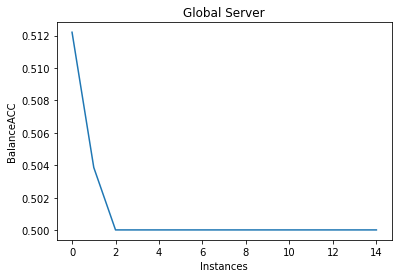

In [14]:
import math
import matplotlib.pyplot as plt
onn_network = global_network
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))
plt.plot(bal_acc_global)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')



In [30]:
print(len(x_test))
print(len(y_test))
x_test, y_test = shuffle(x_test, y_test, random_state=0)
for i in range(len(x_test)-1):
    prediction_1 = global_network.predict_1(np.asarray([x_test[i, :]]))
    global_network.update_eval_metrics(prediction_1,np.asarray([y_test[i]]))
    global_network.update_stp_score(prediction_1,np.asarray([x_test[i, :]]))
    global_network.update_eqop_score(prediction_1,np.asarray([x_test[i, :]]),np.asarray([y_test[i]]))

9769
9769


In [16]:
import math
onn_network = global_network
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

Balanced accuracy: 0.6479251805102212
Sensitivity: 0.3225054531457166
Specificity: 0.9733449078747257
Gmean: 0.5602758611445028
Stp score: -0.0461729828398381
Eqop score: -0.44564886632353884


In [17]:
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

Balanced accuracy: 0.6479251805102212
Sensitivity: 0.3225054531457166
Specificity: 0.9733449078747257
Gmean: 0.5602758611445028
Stp score: -0.0461729828398381
Eqop score: -0.44564886632353884


In [18]:
sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer = [],[],[],[]
sum_alpha = []
scaling_factor = 1/5
global_network2 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
for m in range(3):
    if m==0:
        onn_network=onn_network_1
    elif m==1:
        onn_network=onn_network_2
    else:
        onn_network=onn_network_3
    if sum_alpha==[]:
        sum_alpha = torch.mul(client_alpha, scaling_factor)
        sum_w_output_layer = client_w_output_layer
        sum_b_output_layer = client_b_output_layer
        sum_w_hidden_layer = client_w_hidden_layer
        sum_b_hidden_layer = client_b_hidden_layer
            
        for j in range(onn_network.max_num_hidden_layers):
            sum_w_output_layer[j] = torch.mul(client_w_output_layer[j], scaling_factor)
            sum_b_output_layer[j] = torch.mul(client_b_output_layer[j], scaling_factor)
            sum_w_hidden_layer[j] = torch.mul(client_w_hidden_layer[j], scaling_factor)
            sum_b_hidden_layer[j] = torch.mul(client_b_hidden_layer[j], scaling_factor)

    else:
        sum_alpha = torch.add(sum_alpha, torch.mul(client_alpha, scaling_factor))
        for j in range(onn_network.max_num_hidden_layers):
            sum_w_output_layer[j] = torch.add(sum_w_output_layer[j],torch.mul(client_w_output_layer[j], scaling_factor)) 
            sum_b_output_layer[j] = torch.add(sum_b_output_layer[j],torch.mul(client_b_output_layer[j], scaling_factor))
            sum_w_hidden_layer[j] = torch.add(sum_w_hidden_layer[j],torch.mul(client_w_hidden_layer[j], scaling_factor)) 
            sum_b_hidden_layer[j] = torch.add(sum_b_hidden_layer[j],torch.mul(client_b_hidden_layer[j], scaling_factor))
        
        
global_network2.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)


In [19]:
onn_network_4 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer = onn_network_3.get_weights('local')
onn_network_4.set_weights(galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer)